# Створення базових моделей

**Частина 1**

Необхідно визначити в коді натупне:

1. Базову модель для навчання (виберіть який тип моделі хочете натренувати CNN, MLP тощо).
2. Початкову кількість шарів та їх параметри.
3. Функції для тренування та валідації, візуалізації результатів, фінкцію втрат та метрику перевірки результатів.
4. Натренуйте модель і перевірте результат. Яке значення функції втрат, яка метрика вашої моделі після навчання? Візуалізуйте графіки навчання. Скільки часу потрібно було на тренування?

**Частина 2**

1. Опишіть гіперпараметри моделі: кількість шарів/кількість нейронів в шарах, різні їх комбінації.
2. Підберіть та перевірте найкращі гіперпараметри вашої моделі за яких метрика під час валідації буде найвищою. Скільки часу потрібно було на підбір гіперпараметрів моделі?
3. Продемонструйте на яких класах та зображеннях найчастіше помиляється найкраща модель.
4. Візуалізувати графіки залежностей між гіперпараметрами найкращої моделі і змінами значень її метрики.

In [2]:
%pip install optuna torch matplotlib torchvision plotly pandas


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

In [3]:
datasets_path = './datasets'

train_dataset = FashionMNIST(
    datasets_path,
    train=True,
    download=True,
    transform=transform
)
validation_dataset = FashionMNIST(
    datasets_path,
    train=False,
    transform=transform
)

In [4]:
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)
validation_loader = DataLoader(dataset=validation_dataset, shuffle=False)

In [5]:
plt_size = 2
plt_images = 8
IMAGE_SIZE = 28
CLASSES_N = len(set([i.item() for x,y in train_loader for i in y]))
EPOCHS = 10
N_TRAIN_EXAMPLES=20
N_VALID_EXAMPLES=20

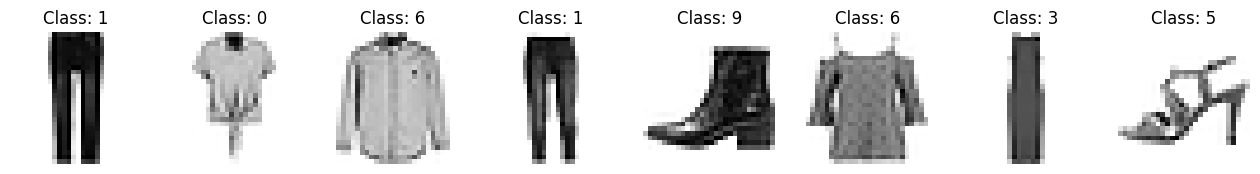

In [6]:
for (X_train, y_train) in train_loader:
    plt.figure(figsize=(plt_images * plt_size, plt_size))

    for i in range(plt_images):
        plt.subplot(1, plt_images, i + 1)
        plt.axis('off')
        plt.imshow(X_train[i, :, :, :].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap="gray_r")
        plt.title(f'Class: {y_train[i].item()}')

    break

In [7]:
# define_model
from optuna.trial import TrialState, Trial

def define_model(trial: Trial):
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []

    conv_kernel_3 = 3
    pool_kernel_2 = 2

    in_features = 1
    image_size = [IMAGE_SIZE, IMAGE_SIZE]
    for i in range(n_layers):
        out_features = trial.suggest_int(f'n_units_l{i}', 4, 128, 4)
        layers.append(torch.nn.Conv2d(in_features, out_features, kernel_size=conv_kernel_3, stride=1, padding=(conv_kernel_3 - 1) // 2))
        layers.append(torch.nn.ReLU())
        layers.append(torch.nn.MaxPool2d(kernel_size=pool_kernel_2, stride=pool_kernel_2))
        in_features = out_features
        image_size[0] //= pool_kernel_2
        image_size[1] //= pool_kernel_2

    layers.append(torch.nn.Flatten())
    layers.append(torch.nn.Linear(in_features * image_size[0] * image_size[1], CLASSES_N))
    layers.append(torch.nn.LogSoftmax(dim=1))

    return torch.nn.Sequential(*layers)


/Users/mp/.pyenv/versions/3.10.10/envs/kma-nn-3.10.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
def train_validate(model, optimizer, scheduler):
    model.train()
    train_loss = 0.0
    for batch_idx, (X_train, y_train) in enumerate(train_loader):
        if batch_idx * len(X_train) >= N_TRAIN_EXAMPLES:
            break
        data, target = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validation loop
    model.eval()
    correct = 0
    validation_loss = 0.0
    with torch.no_grad():
        for batch_idx, (X_valid, y_valid) in enumerate(validation_loader):
            if batch_idx * len(X_valid) >= N_VALID_EXAMPLES:
                break
            data, target = X_valid.to(device), y_valid.to(device)
            output = model(data)
            loss = F.nll_loss(output, target)
            validation_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    avg_validation_loss = validation_loss / len(validation_loader)
    avg_accuracy = correct / min(len(validation_loader.dataset), N_VALID_EXAMPLES)

    # Adjust learning rate
    scheduler.step()

    return avg_validation_loss, avg_accuracy


In [16]:
class MyNN(torch.nn.Module):
  def __init__(self) -> None:
    super(MyNN, self).__init__()
    conv_kernel_3 = 3
    pool_kernel_2 = 2

    in_features = 1
    out_features = 24
    image_size = [IMAGE_SIZE, IMAGE_SIZE]

    self.conv = torch.nn.Conv2d(in_features, out_features, kernel_size=conv_kernel_3, stride=1, padding=(conv_kernel_3 - 1) // 2)
    self.relu = torch.nn.ReLU()
    self.pool = torch.nn.MaxPool2d(kernel_size=pool_kernel_2, stride=pool_kernel_2)

    in_features = out_features
    image_size[0] //= pool_kernel_2
    image_size[1] //= pool_kernel_2

    self.flatten = nn.Flatten()
    self.relu_out = nn.ReLU()
    self.fc = torch.nn.Linear(in_features * image_size[0] * image_size[1], CLASSES_N)
    self.sm = torch.nn.LogSoftmax(dim=1)

  def forward(self, x):
    x = self.conv(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.flatten(x)
    x = self.relu_out(x)
    x = self.fc(x)
    x = self.sm(x)
    return x


In [24]:
import torch
import torch.nn as nn

avg_accuracies = []
avg_losses = []

def train_loop(model: nn.Module, optimizer, scheduler, train_loader, num_epochs=EPOCHS):
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()
            
            running_loss += loss.item()
        
        scheduler.step()
        average_loss = running_loss / len(train_loader)
        avg_accuracy = correct / N_TRAIN_EXAMPLES

        avg_accuracies.append(avg_accuracy)
        avg_losses.append(average_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}")

    print("Training complete!")

    torch.save(model.state_dict(), 'model.pth')

    plt.plot(range(1, num_epochs + 1), avg_losses, label='Average Loss')
    plt.plot(range(1, num_epochs + 1), avg_accuracies, label='Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()


In [ ]:
import os

import optuna
from optuna.trial import TrialState
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms


DEVICE = torch.device("cpu")
BATCHSIZE = 128
CLASSES = 10
DIR = os.getcwd()
EPOCHS = 10
N_TRAIN_EXAMPLES = BATCHSIZE * 30
N_VALID_EXAMPLES = BATCHSIZE * 10


def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []

    in_features = 28 * 28
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, CLASSES))
    layers.append(nn.LogSoftmax(dim=1))

    return nn.Sequential(*layers)


def get_mnist():
    # Load FashionMNIST dataset.
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(DIR, train=True, download=True, transform=transforms.ToTensor()),
        batch_size=BATCHSIZE,
        shuffle=True,
    )
    valid_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(DIR, train=False, transform=transforms.ToTensor()),
        batch_size=BATCHSIZE,
        shuffle=True,
    )

    return train_loader, valid_loader


def objective(trial):
    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Get the FashionMNIST dataset.
    train_loader, valid_loader = get_mnist()

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / min(len(valid_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy


In [ ]:
# correct

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [23]:

model = MyNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1)

train_loop(model, optimizer, scheduler, train_loader)


Epoch [1/5], Loss: 0.3770
Epoch [2/5], Loss: 0.2492
Epoch [3/5], Loss: 0.2304
Epoch [4/5], Loss: 0.2281
Epoch [5/5], Loss: 0.2278
Training complete!


Epoch 1/100, Loss: 0.0117, Accuracy: 0.1500
Epoch 2/100, Loss: 0.0111, Accuracy: 0.1500
Epoch 3/100, Loss: 0.0111, Accuracy: 0.1500
Epoch 4/100, Loss: 0.0111, Accuracy: 0.1500
Epoch 5/100, Loss: 0.0111, Accuracy: 0.1500
Epoch 6/100, Loss: 0.0111, Accuracy: 0.1500
Epoch 7/100, Loss: 0.0111, Accuracy: 0.1500
Epoch 8/100, Loss: 0.0111, Accuracy: 0.1500
Epoch 9/100, Loss: 0.0111, Accuracy: 0.1500
Epoch 10/100, Loss: 0.0111, Accuracy: 0.1500
Epoch 11/100, Loss: 0.0111, Accuracy: 0.1500
Epoch 12/100, Loss: 0.0111, Accuracy: 0.1500
Epoch 13/100, Loss: 0.0111, Accuracy: 0.1500
Epoch 14/100, Loss: 0.0111, Accuracy: 0.1500
Epoch 15/100, Loss: 0.0111, Accuracy: 0.1500
Epoch 16/100, Loss: 0.0111, Accuracy: 0.1500
Epoch 17/100, Loss: 0.0111, Accuracy: 0.1500
Epoch 18/100, Loss: 0.0111, Accuracy: 0.1500
Epoch 19/100, Loss: 0.0111, Accuracy: 0.1500
Epoch 20/100, Loss: 0.0111, Accuracy: 0.1500
Epoch 21/100, Loss: 0.0111, Accuracy: 0.1500
Epoch 22/100, Loss: 0.0111, Accuracy: 0.1500
Epoch 23/100, Loss:

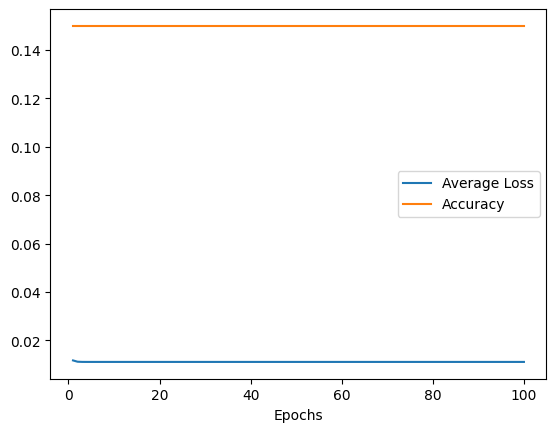

In [21]:
# Training loop
EPOCHS = 100  # Adjust as needed
avg_accuracies = []
avg_losses = []

model = MyNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1)

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0
    for batch_idx, (X_train, y_train) in enumerate(train_loader):
        if batch_idx * len(X_train) >= N_TRAIN_EXAMPLES:
            break
        data, target = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validation loop
    model.eval()
    correct = 0
    validation_loss = 0.0
    with torch.no_grad():
        for batch_idx, (X_valid, y_valid) in enumerate(validation_loader):
            if batch_idx * len(X_valid) >= N_VALID_EXAMPLES:
                break
            data, target = X_valid.to(device), y_valid.to(device)
            output = model(data)
            loss = F.nll_loss(output, target)
            validation_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    avg_validation_loss = validation_loss / len(validation_loader)
    avg_accuracy = correct / min(len(validation_loader.dataset), N_VALID_EXAMPLES)

    # Adjust learning rate
    scheduler.step()

    avg_accuracies.append(avg_accuracy)
    avg_losses.append(avg_validation_loss)

    print(f"Epoch {epoch}/{EPOCHS}, Loss: {avg_validation_loss:.4f}, Accuracy: {avg_accuracy:.4f}")

# Save the trained model
torch.save(model.state_dict(), 'model.pth')

# Visualize learning curves
plt.plot(range(1, EPOCHS + 1), avg_losses, label='Average Loss')
plt.plot(range(1, EPOCHS + 1), avg_accuracies, label='Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [11]:
# objective
# CNN - Початкову кількість шарів та їх параметри.
# CNN: spatial relationships, translation-invariant features
import torch
import optuna
import torch.nn.functional as F

train_losses = []
validation_losses = []
accuracies = []

def objective(trial):
    # Generate the model.
    model = define_model(trial).to(device)
    print(model)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(EPOCHS):
        loss, avg_accuracy = train_loop(model, optimizer)
        trial.report(avg_accuracy, epoch)
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return avg_accuracy




In [30]:
from torch import optim

def objective(trial):
    global train_loader, validation_loader, avg_accuracies, avg_losses
    # Generate the model.
    model = define_model(trial).to(device)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0

        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * batch_size >= N_TRAIN_EXAMPLES:
                break

            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(validation_loader):
                # Limiting validation data.
                if batch_idx * batch_size >= N_VALID_EXAMPLES:
                    break
                data, target = data.to(device), target.to(device)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                running_loss += loss.item()

        accuracy = correct / min(len(validation_loader.dataset), N_VALID_EXAMPLES)

        average_loss = running_loss / len(train_loader)
        avg_accuracy = correct / N_TRAIN_EXAMPLES

        avg_accuracies.append(avg_accuracy)
        avg_losses.append(average_loss)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [31]:
# main
from optuna.visualization import plot_contour, plot_optimization_history

study = optuna.create_study(direction="maximize")
train_losses = []
validation_losses = []
accuracies = []
study.optimize(objective, n_trials=100, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2023-11-06 09:21:30,688] A new study created in memory with name: no-name-34c4f5e0-7e1f-49a2-9403-c8f6b62667b9
[I 2023-11-06 09:21:32,215] Trial 0 finished with value: 0.0 and parameters: {'n_layers': 3, 'n_units_l0': 24, 'n_units_l1': 92, 'n_units_l2': 96, 'optimizer': 'RMSprop', 'lr': 8.071231324343542e-05}. Best is trial 0 with value: 0.0.
[I 2023-11-06 09:21:33,203] Trial 1 finished with value: 0.05 and parameters: {'n_layers': 3, 'n_units_l0': 24, 'n_units_l1': 12, 'n_units_l2': 92, 'optimizer': 'SGD', 'lr': 0.08883251532487642}. Best is trial 1 with value: 0.05.
[I 2023-11-06 09:21:33,843] Trial 2 finished with value: 0.0 and parameters: {'n_layers': 2, 'n_units_l0': 16, 'n_units_l1': 12, 'optimizer': 'SGD', 'lr': 0.00012793685963352462}. Best is trial 1 with value: 0.05.
[I 2023-11-06 09:21:35,824] Trial 3 finished with value: 0.0 and parameters: {'n_layers': 2, 'n_units_l0': 104, 'n_units_l1': 120, 'optimizer': 'SGD', 'lr': 0.0005442079189911758}. Best is trial 1 with value:

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  25
  Number of complete trials:  75
Best trial:
  Value:  0.05
  Params: 
    n_layers: 3
    n_units_l0: 24
    n_units_l1: 12
    n_units_l2: 92
    optimizer: SGD
    lr: 0.08883251532487642


In [13]:
import torch
import torch.nn.functional as F

best_trial = study.best_trial
best_model = define_model(best_trial)
best_model.eval()

correct = 0
total = 0
class_correct = [0 for _ in range(CLASSES_N)]
class_total = [0 for _ in range(CLASSES_N)]

with torch.no_grad():
    for data, labels in validation_loader:
        outputs = best_model(data)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        c = (predicted == labels).squeeze()
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c.item()
            class_total[label] += 1

class_accuracy = [class_correct[i] / class_total[i] for i in range(CLASSES_N)]
most_unpredictable_class = class_accuracy.index(min(class_accuracy))

print(f"Most unpredictable class: {most_unpredictable_class}")
print(f"Accuracy for each class: {class_accuracy}")


Most unpredictable class: 0
Accuracy for each class: [0.0, 0.0, 0.014, 0.0, 0.994, 0.002, 0.0, 0.0, 0.0, 0.0]


In [14]:
best_trial = study.best_trial
plot_optimization_history(study).show(renderer="browser")
hyperparams = [f'n_units_l{i}' for i in range(2)] + ['n_layers']
plot_contour(study, params=hyperparams).show(renderer="browser")
plt.show()


![Alt Text](charts/optuna-report.png)

![Alt Text](charts/optuna-objective.png)

### JUPYTER STORES EXECUTION TIME OF EACH CELL